In [1]:
import numpy as np
import scipy.integrate
from plotnine import *
import matplotlib.pylab as plt
import pandas as pd

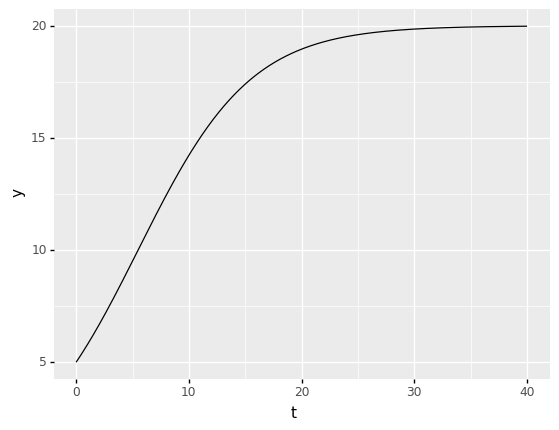

<ggplot: (8749598640285)>

In [2]:
def ode(y, t, r, k):
    return r * y * (1 - y/k)

def solve_ode(times, r, k, y0):
    s = scipy.integrate.odeint(ode, [y0], times, args=(r, k))
    df = pd.DataFrame({'t': times, 'y': s[:, 0]})
    return df

df = solve_ode(np.linspace(0, 40, 1000), 0.2, 20, 5)
(
    ggplot(df, aes(x='t', y='y')) +
    geom_line()
)

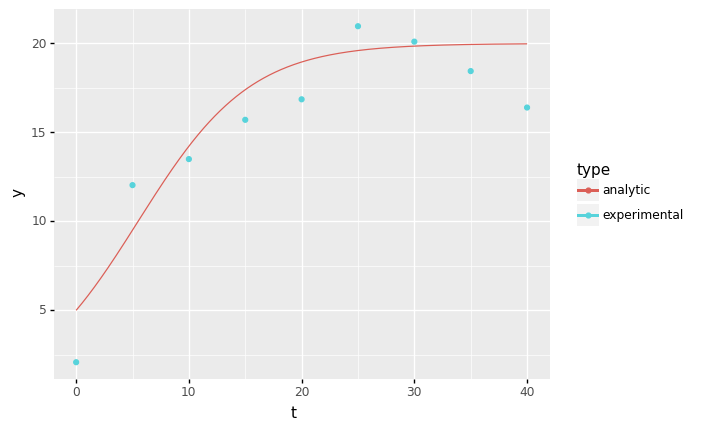

<ggplot: (8749596434704)>

In [3]:
def noise(mean, sigma):
    return np.random.normal(mean, sigma)

ts = np.arange(0, 45, 5)
df_obs = solve_ode(ts, 0.2, 20, 5)
df_obs['y'] = noise(df_obs['y'], 2)
df['type'] = 'analytic'
df_obs['type'] = 'experimental'

(
    ggplot() + 
    geom_line(aes(x='t', y='y', colour='type'), data=df) + 
    geom_point(aes(x='t', y='y', colour='type'), data=df_obs)
)

In [4]:
import scipy.stats

def log_likelihood(times, y_obs, r, k, y0, sigma):
    df = solve_ode(times, r, k, y0)
    log_p = 0
    for i in range(len(times)):
        log_p += scipy.stats.norm.logpdf(y_obs[i], df['y'][i], sigma)
    return log_p

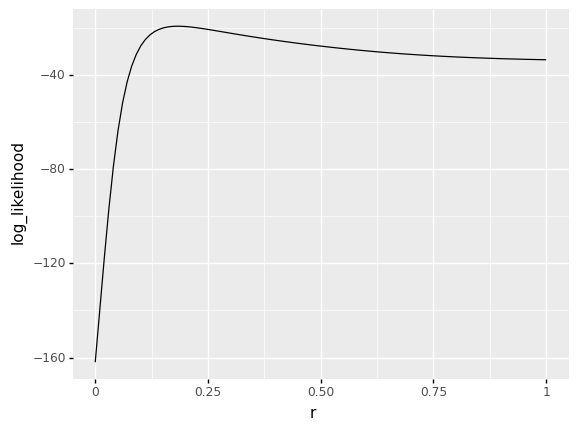

<ggplot: (8749596355163)>

In [5]:
likelihood_df = pd.DataFrame(columns=['r', 'log_likelihood']).set_index('r')

for r in np.linspace(0, 1, 100):
    likelihood_df.loc[r] = log_likelihood(df_obs['t'], df_obs['y'], r, 20, 5, 2)
likelihood_df.reset_index(inplace=True, drop=False)

(
    ggplot(likelihood_df, aes(x='r', y='log_likelihood')) +
    geom_line()
)

/tmp/ipykernel_263526/829685299.py:2: RuntimeWarning: divide by zero encountered in true_divide
/home/sabsr3/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.5000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.1000000000000D+02
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in

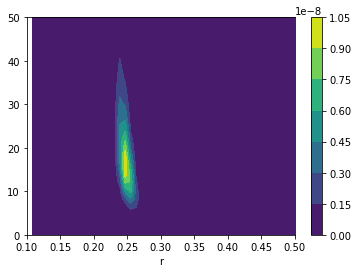

In [6]:
r = np.linspace(0.1, 0.5, 50); k = np.linspace(0, 50, 50)
X, Y = np.meshgrid(r, k); Z = np.zeros_like(X)
for i in range(len(r)):
    for j in range(len(k)):
        Z[i, j] = log_likelihood(df_obs['t'], df_obs['y'], r[i], k[j], 5, 2)
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(X, Y, np.exp(Z)); fig.colorbar(cp)
ax.set_xlabel('r'); ax.set_label('k')
plt.show()

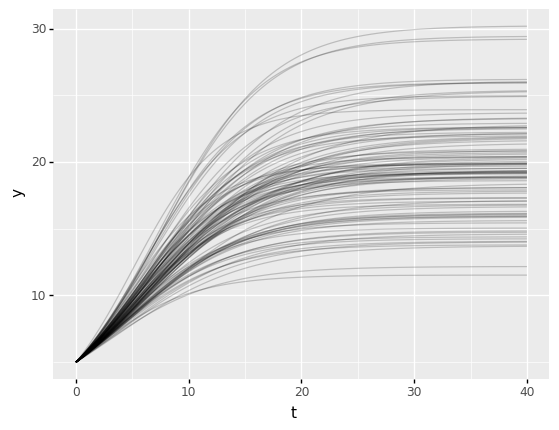

<ggplot: (8749594159222)>

In [7]:
for n in range(100):
    r = np.random.normal(0.2, 0.02, 1); k = np.random.normal(20, 4, 1)
    tmp_df = solve_ode(np.linspace(0, 40, 100), r, k, 5)
    tmp_df['run'] = str(n)
    if n == 0:
        df_predictions = tmp_df
    else:
        df_predictions = pd.concat([df_predictions, tmp_df])

(
    ggplot(df_predictions, aes(x='t', y='y', group='run')) +
    geom_line(alpha=0.2)
)

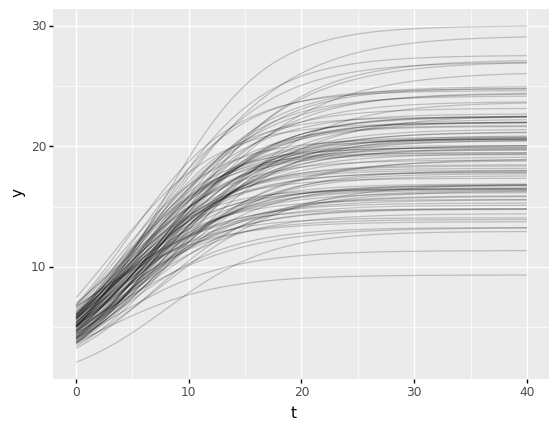

<ggplot: (8749594047666)>

In [8]:
for n in range(100):
    r = np.random.normal(0.2, 0.02, 1); k = np.random.normal(20, 4, 1)
    y0 = np.random.normal(5, 1, 1)[0]
    tmp_df = solve_ode(np.linspace(0, 40, 100), r, k, y0)
    tmp_df['run'] = str(n)
    if n == 0:
        df_predictions = tmp_df
    else:
        df_predictions = pd.concat([df_predictions, tmp_df])

(
    ggplot(df_predictions, aes(x='t', y='y', group='run')) +
    geom_line(alpha=0.2)
)

In [9]:
def propose(r, k, sigma, tau_r, tau_k, tau_sigma):
    return np.random.normal(r, tau_r), np.random.normal(k, tau_k), np.random.normal(sigma, tau_sigma)

In [10]:
def prior(r, k, sigma):
    return (scipy.stats.norm.logpdf(r, 0.2, 0.02) +
        scipy.stats.norm.logpdf(k, 20, 4) +
        scipy.stats.norm.logpdf(sigma, 2, 0.2))

def posterior(r, k, sigma, y0, times, y_obs):
    ll = log_likelihood(times, y_obs, r, k, y0, sigma)
    lp = prior(r, k, sigma)
    return ll + lp

In [11]:
def step(r, k, sigma, y0, times, y_obs, tau_r, tau_k, tau_sigma):
    r_prime, k_prime, sigma_prime = propose(r, k, sigma, tau_r, tau_k, tau_sigma)
    logp_current = posterior(r, k, sigma, y0, times, y_obs)
    logp_proposed = posterior(r_prime, k_prime, sigma_prime, y0, times, y_obs)
    t = np.exp(logp_proposed - logp_current)
    u = np.random.uniform()
    if t > u:
        return r_prime, k_prime, sigma_prime
    else:
        return r, k, sigma

In [12]:
def MCMC(numsamples, r, k, sigma, y0, times, y_obs, tau_r, tau_k, tau_sigma):
    r = np.random.normal(0.2, 0.02)
    k = np.random.normal(20, 4)
    sigma = np.random.normal(2, 0.2)
    m_samples = np.zeros((numsamples, 3))
    m_samples[0, :] = [r, k, sigma]
    for i in range(1, numsamples):
        r, k, sigma = step(r, k, sigma, y0, times, y_obs, tau_r, tau_k, tau_sigma)
        m_samples[i, :] = [r, k, sigma]
    return pd.DataFrame({
        'r': m_samples[:, 0],
        'k': m_samples[:, 1],
        'sigma': m_samples[:, 2],
        'iter': np.arange(0, numsamples)})

In [13]:
mcmc_df = MCMC(1000, 0.2, 18, 1.5, 5, df_obs['t'], df_obs['y'], 0.01, 1, 0.1)

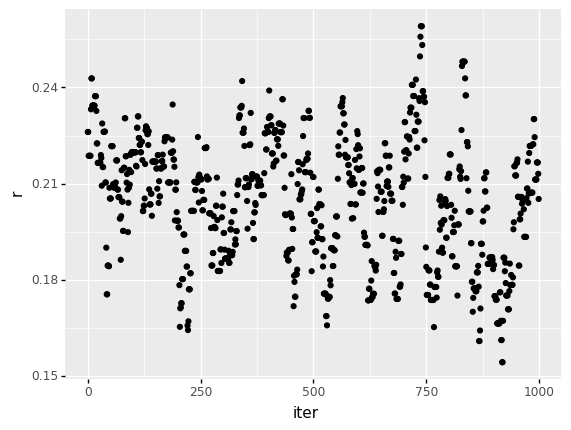

<ggplot: (8749592344194)>

In [14]:
(
    ggplot(mcmc_df, aes(x='iter', y='r')) +
    geom_point()
)

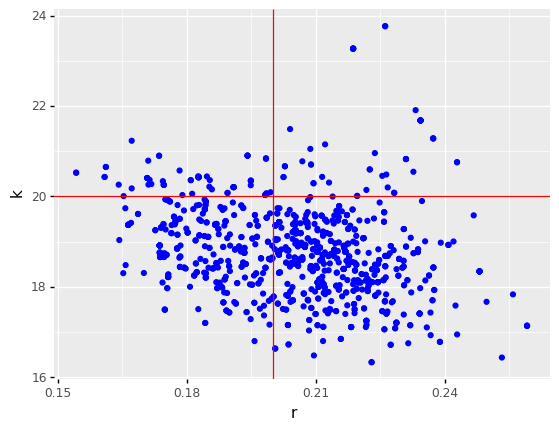

<ggplot: (8749592285064)>

In [15]:
(
    ggplot(mcmc_df, aes(x='r', y='k')) + 
    geom_point(color='blue') +
    geom_vline(xintercept=0.2, color='red') +
    geom_hline(yintercept=20, color='red')
)

In [16]:
def truncated_normal(mu, sd):
    myclip_a = 0
    myclip_b = 1000000
    my_mean = mu
    my_std = sd

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    r = scipy.stats.truncnorm.rvs(a, b, loc=my_mean, scale=my_std, size=1)
    return r[0]

In [17]:
def MCMC_truncated(numsamples, r, k, sigma, y0, times, y_obs, tau_r, tau_k, tau_sigma):
    r = truncated_normal(0.2, 0.02)
    k = truncated_normal(20, 4)
    sigma = truncated_normal(2, 0.2)
    m_samples = np.zeros((numsamples, 3))
    m_samples[0, :] = [r, k, sigma]
    for i in range(1, numsamples):
        r, k, sigma = step(r, k, sigma, y0, times, y_obs, tau_r, tau_k, tau_sigma)
        m_samples[i, :] = [r, k, sigma]
    return pd.DataFrame({
        'r': m_samples[:, 0],
        'k': m_samples[:, 1],
        'sigma': m_samples[:, 2],
        'iter': np.arange(0, numsamples)})

mcmc_truncated_df = pd.DataFrame()
for i in range(4):
    df = MCMC_truncated(1000, 0.2, 18, 1.5, 5, df_obs['t'], df_obs['y'], 0.01, 1, 0.1)
    df['chain'] = str(i+1)
    mcmc_truncated_df = pd.concat([mcmc_truncated_df, df])

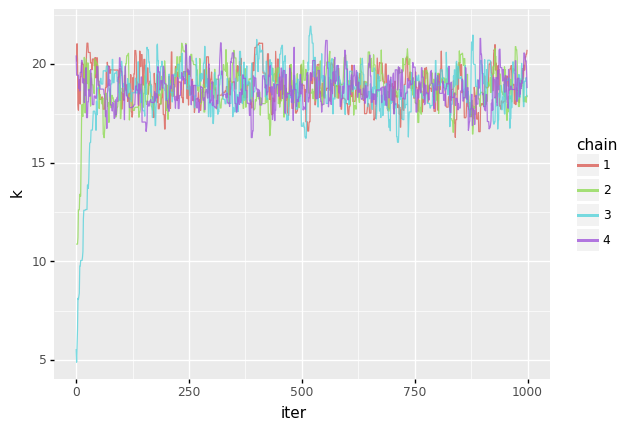

<ggplot: (8749592297301)>

In [18]:
(
    ggplot(mcmc_truncated_df, aes(x='iter', y='k', color='chain')) +
    geom_line(alpha=0.8)
)

In [19]:
df_samples = mcmc_truncated_df.query('iter > 500'); n_samples = 100
idx = np.random.randint(len(df_samples), size=n_samples)
df_samples = df_samples.sample(n=n_samples)
df_simulations = pd.DataFrame()

for i in range(n_samples):
    r = df_samples['r'].iloc[i]
    k = df_samples['k'].iloc[i]
    df = solve_ode(np.linspace(0, 40, 100), r, k, 5)
    df['run'] = str(i)
    df_simulations = pd.concat([df_simulations, df])

df_simulations['type'] = 'simulation'

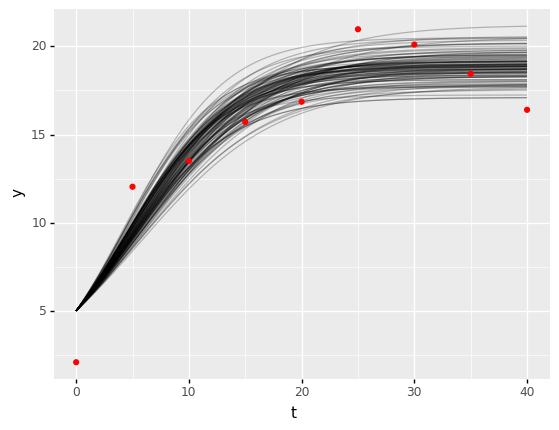

<ggplot: (8749592344149)>

In [20]:
(
    ggplot() +
    geom_line(aes(x='t', y='y', group='run'), data=df_simulations, alpha=0.25) +
    geom_point(aes(x='t', y='y'), data=df_obs, color='red')
)